<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 772, '日付': '2021-05-15T08:00:00.000Z'},
 {'小計': 542, '日付': '2021-05-16T08:00:00.000Z'},
 {'小計': 419, '日付': '2021-05-17T08:00:00.000Z'},
 {'小計': 732, '日付': '2021-05-18T08:00:00.000Z'},
 {'小計': 766, '日付': '2021-05-19T08:00:00.000Z'},
 {'小計': 843, '日付': '2021-05-20T08:00:00.000Z'},
 {'小計': 649, '日付': '2021-05-21T08:00:00.000Z'},
 {'小計': 602, '日付': '2021-05-22T08:00:00.000Z'},
 {'小計': 535, '日付': '2021-05-23T08:00:00.000Z'},
 {'小計': 340, '日付': '2021-05-24T08:00:00.000Z'},
 {'小計': 542, '日付': '2021-05-25T08:00:00.000Z'},
 {'小計': 743, '日付': '2021-05-26T08:00:00.000Z'},
 {'小計': 684, '日付': '2021-05-27T08:00:00.000Z'},
 {'小計': 614, '日付': '2021-05-28T08:00:00.000Z'},
 {'小計': 539, '日付': '2021-05-29T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-05-25 17:00:00+09:00,455,0,542,2021-05-25 17:00:00+09:00
2021-05-26 17:00:00+09:00,424,0,743,2021-05-26 17:00:00+09:00
2021-05-27 17:00:00+09:00,426,0,684,2021-05-27 17:00:00+09:00
2021-05-28 17:00:00+09:00,0,0,614,2021-05-28 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-05-25 17:00:00+09:00,455,0,542,2021-05-25 17:00:00+09:00,487.285714,3411.0,0.0,0.0,611.000000,4277.0
2021-05-26 17:00:00+09:00,424,0,743,2021-05-26 17:00:00+09:00,468.000000,3276.0,0.0,0.0,607.714286,4254.0
2021-05-27 17:00:00+09:00,426,0,684,2021-05-27 17:00:00+09:00,459.000000,3213.0,0.0,0.0,585.000000,4095.0
2021-05-28 17:00:00+09:00,0,0,614,2021-05-28 17:00:00+09:00,387.000000,2709.0,0.0,0.0,580.000000,4060.0
2021-05-29 17:00:00+09:00,0,0,539,2021-05-29 17:00:00+09:00,314.285714,2200.0,0.0,0.0,571.000000,3997.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00,632.285714,4426.0,0.0,0.0,876.428571,6135.0,'21w19,Sat
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00,613.285714,4293.0,0.0,0.0,806.428571,5645.0,'21w19,Sun
2021-05-17 17:00:00+09:00,703,0,419,2021-05-17 17:00:00+09:00,615.428571,4308.0,0.0,0.0,784.428571,5491.0,'21w20,Mon
2021-05-18 17:00:00+09:00,569,0,732,2021-05-18 17:00:00+09:00,612.000000,4284.0,0.0,0.0,756.857143,5298.0,'21w20,Tue
2021-05-19 17:00:00+09:00,559,0,766,2021-05-19 17:00:00+09:00,603.000000,4221.0,0.0,0.0,727.857143,5095.0,'21w20,Wed
2021-05-20 17:00:00+09:00,489,0,843,2021-05-20 17:00:00+09:00,581.857143,4073.0,0.0,0.0,704.000000,4928.0,'21w20,Thu
2021-05-21 17:00:00+09:00,504,0,649,2021-05-21 17:00:00+09:00,568.571429,3980.0,0.0,0.0,674.714286,4723.0,'21w20,Fri
2021-05-22 17:00:00+09:00,509,0,602,2021-05-22 17:00:00+09:00,549.142857,3844.0,0.0,0.0,650.428571,4553.0,'21w20,Sat
2021-05-23 17:00:00+09:00,362,0,535,2021-05-23 17:00:00+09:00,527.857143,3695.0,0.0,0.0,649.428571,4546.0,'21w20,Sun
2021-05-24 17:00:00+09:00,533,0,340,2021-05-24 17:00:00+09:00,503.571429,3525.0,0.0,0.0,638.142857,4467.0,'21w21,Mon


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-05-09 17:00:00+09:00,798.428571,5589
2021-05-16 17:00:00+09:00,806.428571,5645
2021-05-23 17:00:00+09:00,649.428571,4546
2021-05-29 17:00:00+09:00,577.000000,3462
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-05-15 17:00:00+09:00,645,0,772,2021-05-15 17:00:00+09:00,632.285714,4426.0,0.0,0.0,876.428571,6135.0,'21w19,Sat,NaN,NaN
2021-05-16 17:00:00+09:00,511,0,542,2021-05-16 17:00:00+09:00,613.285714,4293.0,0.0,0.0,806.428571,5645.0,'21w19,Sun,806.428571,5645.0
2021-05-17 17:00:00+09:00,703,0,419,2021-05-17 17:00:00+09:00,615.428571,4308.0,0.0,0.0,784.428571,5491.0,'21w20,Mon,NaN,NaN
2021-05-18 17:00:00+09:00,569,0,732,2021-05-18 17:00:00+09:00,612.000000,4284.0,0.0,0.0,756.857143,5298.0,'21w20,Tue,NaN,NaN
2021-05-19 17:00:00+09:00,559,0,766,2021-05-19 17:00:00+09:00,603.000000,4221.0,0.0,0.0,727.857143,5095.0,'21w20,Wed,NaN,NaN
2021-05-20 17:00:00+09:00,489,0,843,2021-05-20 17:00:00+09:00,581.857143,4073.0,0.0,0.0,704.000000,4928.0,'21w20,Thu,NaN,NaN
2021-05-21 17:00:00+09:00,504,0,649,2021-05-21 17:00:00+09:00,568.571429,3980.0,0.0,0.0,674.714286,4723.0,'21w20,Fri,NaN,NaN
2021-05-22 17:00:00+09:00,509,0,602,2021-05-22 17:00:00+09:00,549.142857,3844.0,0.0,0.0,650.428571,4553.0,'21w20,Sat,NaN,NaN
2021-05-23 17:00:00+09:00,362,0,535,2021-05-23 17:00:00+09:00,527.857143,3695.0,0.0,0.0,649.428571,4546.0,'21w20,Sun,649.428571,4546.0
2021-05-24 17:00:00+09:00,533,0,340,2021-05-24 17:00:00+09:00,503.571429,3525.0,0.0,0.0,638.142857,4467.0,'21w21,Mon,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

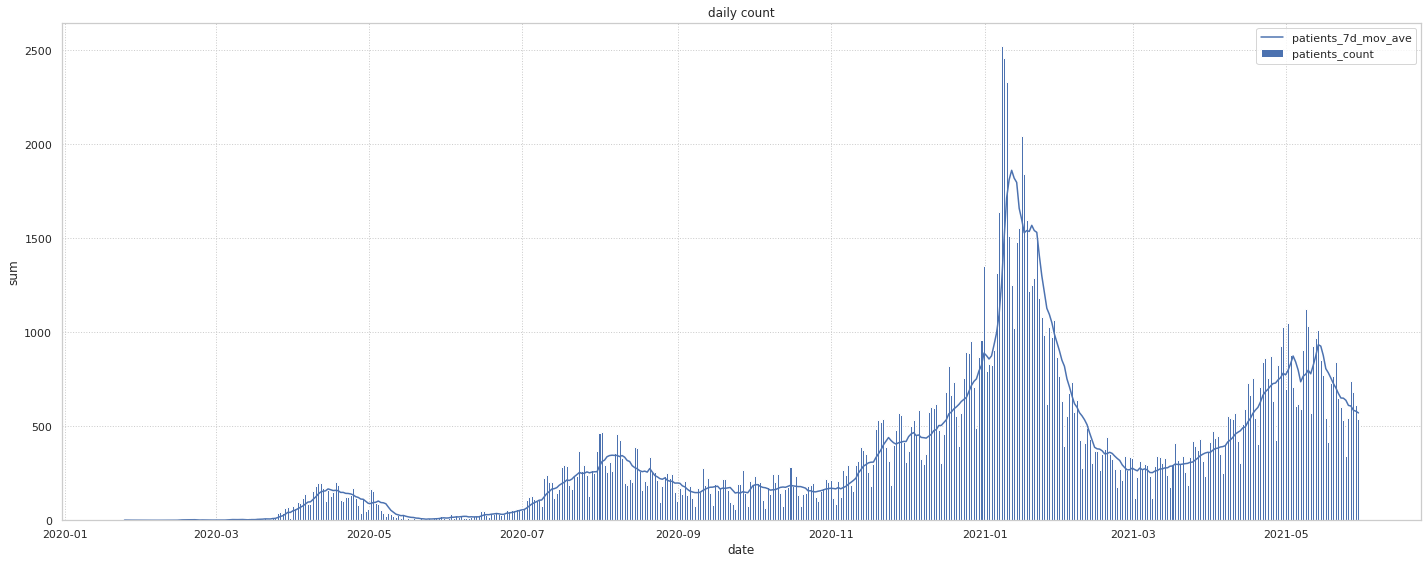

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
477,1.621066e+09,2021,5,15,0,0,1,0,0,0,0,477,0,403,645,632.285714,4426.0,0,0.0,0.0,772,876.428571,6135.0
478,1.621152e+09,2021,5,16,0,0,0,1,0,0,0,478,0,404,511,613.285714,4293.0,0,0.0,0.0,542,806.428571,5645.0
479,1.621238e+09,2021,5,17,0,1,0,0,0,0,0,479,0,405,703,615.428571,4308.0,0,0.0,0.0,419,784.428571,5491.0
480,1.621325e+09,2021,5,18,0,0,0,0,0,1,0,480,0,406,569,612.000000,4284.0,0,0.0,0.0,732,756.857143,5298.0
481,1.621411e+09,2021,5,19,0,0,0,0,0,0,1,481,0,407,559,603.000000,4221.0,0,0.0,0.0,766,727.857143,5095.0
482,1.621498e+09,2021,5,20,0,0,0,0,1,0,0,482,0,408,489,581.857143,4073.0,0,0.0,0.0,843,704.000000,4928.0
483,1.621584e+09,2021,5,21,1,0,0,0,0,0,0,483,0,409,504,568.571429,3980.0,0,0.0,0.0,649,674.714286,4723.0
484,1.621670e+09,2021,5,22,0,0,1,0,0,0,0,484,0,410,509,549.142857,3844.0,0,0.0,0.0,602,650.428571,4553.0
485,1.621757e+09,2021,5,23,0,0,0,1,0,0,0,485,0,411,362,527.857143,3695.0,0,0.0,0.0,535,649.428571,4546.0
486,1.621843e+09,2021,5,24,0,1,0,0,0,0,0,486,0,412,533,503.571429,3525.0,0,0.0,0.0,340,638.142857,4467.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            492 non-null    float64
 1   year                 492 non-null    int64  
 2   month                492 non-null    int64  
 3   day                  492 non-null    int64  
 4   Fri                  492 non-null    uint8  
 5   Mon                  492 non-null    uint8  
 6   Sat                  492 non-null    uint8  
 7   Sun                  492 non-null    uint8  
 8   Thu                  492 non-null    uint8  
 9   Tue                  492 non-null    uint8  
 10  Wed                  492 non-null    uint8  
 11  passed               492 non-null    int64  
 12  emergency            492 non-null    int64  
 13  em_passed            492 non-null    int64  
 14  contacts_count       492 non-null    int64  
 15  contacts_7d_mov_ave  492 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.920000e+02,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,1.601064e+09,2020.302846,5.703252,15.831301,0.144309,0.142276,0.144309,0.142276,0.142276,0.142276,0.142276,245.500000,0.099593,177.140244,672.333333,671.051345,4697.351626,749.022358,749.022358,5243.156504,325.705285,322.024477,2254.138211
std,1.228370e+07,0.459957,3.343436,8.821493,0.351760,0.349689,0.351760,0.349689,0.349689,0.349689,0.349689,142.172431,0.299762,134.021925,439.473832,426.109372,2982.777830,872.241316,781.016911,5467.118375,374.358624,353.700326,2475.932452
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.590458e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,122.750000,0.000000,48.750000,390.000000,388.392857,2718.750000,0.000000,0.000000,0.000000,58.750000,60.392857,422.750000
50%,1.601064e+09,2020.000000,5.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,245.500000,0.000000,171.500000,545.500000,562.785714,3939.500000,342.000000,837.714286,5864.000000,211.000000,202.071429,1414.500000
75%,1.611670e+09,2021.000000,8.000000,24.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,368.250000,0.000000,294.250000,783.250000,764.000000,5348.000000,1360.500000,1358.857143,9512.000000,435.500000,439.500000,3076.500000
max,1.622275e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,491.000000,1.000000,417.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.795860,0.081784,0.014415,-0.001446,-0.002868,0.001446,-0.005735,0.005735,-1.545523e-18,0.002868,1.000000e+00,-0.345394,0.995214,-0.279656,-0.260322,-0.260317,-0.522350,-0.563083,-0.563083,0.638590,0.677110,0.677125
year,7.958599e-01,1.000000,-0.536084,-0.030551,0.006268,-0.002522,0.006268,-0.002522,-0.002522,-2.522206e-03,-0.002522,7.958599e-01,-0.219201,0.816494,-0.266293,-0.241604,-0.241602,-0.566560,-0.632736,-0.632736,0.608021,0.663900,0.663900
month,8.178441e-02,-0.536084,1.000000,-0.015995,-0.013734,0.001345,-0.008539,-0.003881,0.011797,4.829396e-03,0.008313,8.178441e-02,-0.118796,0.040777,0.052562,0.038206,0.038209,0.206662,0.260430,0.260430,-0.112658,-0.152167,-0.152146
day,1.441461e-02,-0.030551,-0.015995,1.000000,0.015738,-0.013331,0.001954,-0.000126,0.004495,-7.388658e-03,-0.001447,1.441461e-02,-0.005186,0.016349,-0.028881,-0.022115,-0.022119,0.000176,-0.015792,-0.015792,-0.002973,0.007082,0.007068
Fri,-1.445721e-03,0.006268,-0.013734,0.015738,1.000000,-0.167256,-0.168646,-0.167256,-0.167256,-1.672557e-01,-0.167256,-1.445721e-03,-0.001374,-0.000301,-0.022919,-0.005289,-0.005288,0.032668,-0.003966,-0.003966,0.046196,-0.000777,-0.000785
Mon,-2.867604e-03,-0.002522,0.001345,-0.013331,-0.167256,1.000000,-0.167256,-0.165877,-0.165877,-1.658768e-01,-0.165877,-2.867604e-03,0.000553,-0.002991,0.042060,0.001304,0.001305,0.145488,0.001596,0.001596,-0.128638,-0.001565,-0.001564
Sat,1.445721e-03,0.006268,-0.008539,0.001954,-0.168646,-0.167256,1.000000,-0.167256,-0.167256,-1.672557e-01,-0.167256,1.445721e-03,-0.001374,0.002292,0.040398,-0.005289,-0.005288,-0.168860,-0.003966,-0.003966,0.061260,0.000481,0.000475
Sun,-5.735208e-03,-0.002522,-0.003881,-0.000126,-0.167256,-0.165877,-0.167256,1.000000,-0.165877,-1.658768e-01,-0.165877,-5.735208e-03,0.000553,-0.005555,-0.019512,0.000263,0.000264,-0.151778,0.001596,0.001596,-0.038418,-0.002363,-0.002363
Thu,5.735208e-03,-0.002522,0.011797,0.004495,-0.167256,-0.165877,-0.167256,-0.165877,1.000000,-1.658768e-01,-0.165877,5.735208e-03,0.000553,0.004788,-0.004789,0.003852,0.003853,0.043459,0.001596,0.001596,0.080662,0.003063,0.003068
Tue,-1.545523e-18,-0.002522,0.004829,-0.007389,-0.167256,-0.165877,-0.167256,-0.165877,-0.165877,1.000000e+00,-0.165877,-1.746476e-18,0.000553,-0.000427,-0.022826,0.002192,0.002194,0.058903,0.001596,0.001596,-0.034840,-0.000292,-0.000289


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1.621930e+09,0,0,0,0,0,1,0,487,0,413,455,0,542,611.000000,4277.0
488,1.622016e+09,0,0,0,0,0,0,1,488,0,414,424,0,743,607.714286,4254.0
489,1.622102e+09,0,0,0,0,1,0,0,489,0,415,426,0,684,585.000000,4095.0
490,1.622189e+09,1,0,0,0,0,0,0,490,0,416,0,0,614,580.000000,4060.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
487,1.621930e+09,487,0,542,611.000000,4277.0
488,1.622016e+09,488,0,743,607.714286,4254.0
489,1.622102e+09,489,0,684,585.000000,4095.0
490,1.622189e+09,490,0,614,580.000000,4060.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

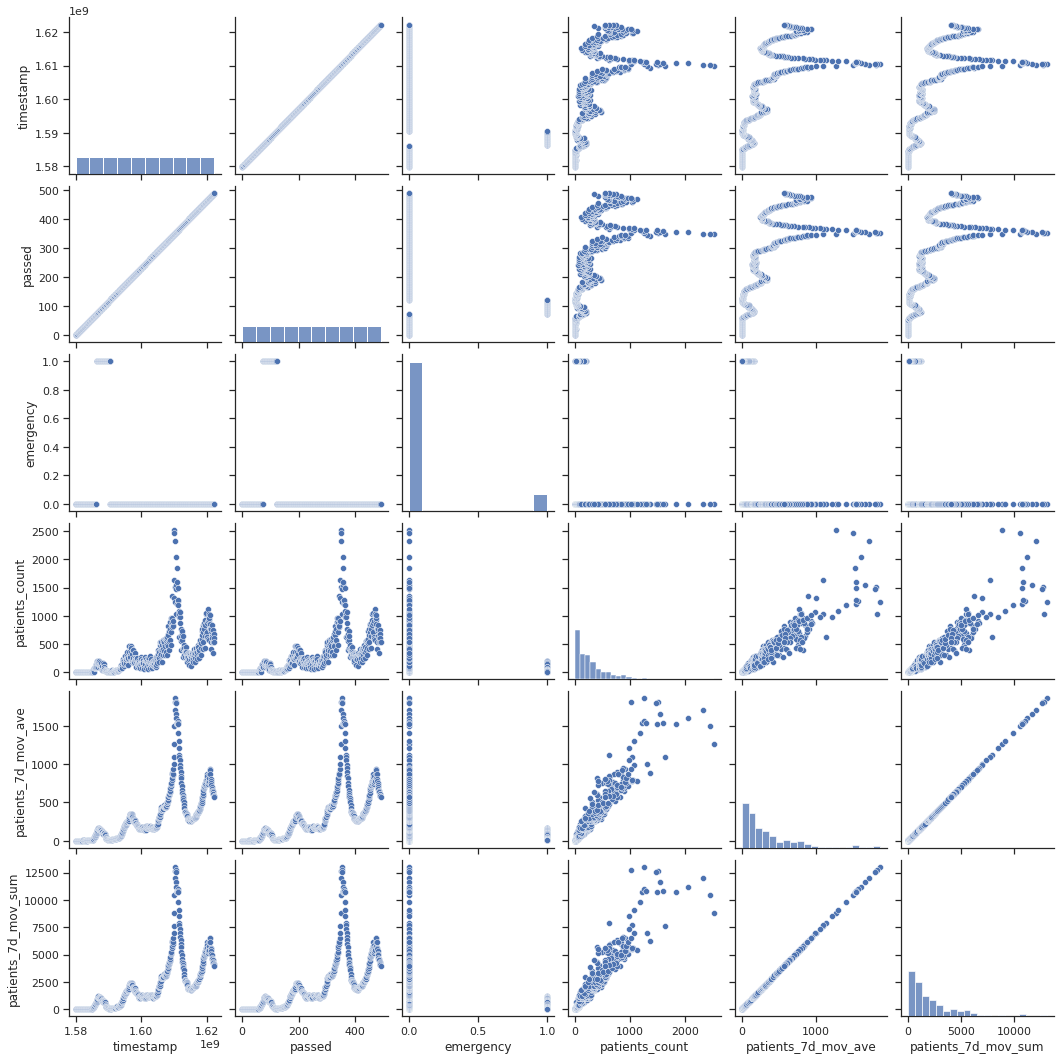

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
